In [ ]:
!pip install yfinance

In [ ]:
import  pandas_datareader.data as web
import numpy as np
import yfinance as yf
import datetime
yf.pdr_override()

start=datetime.datetime(2001,12,1)
end=datetime.datetime(2021,12,1)
apple=web.get_data_yahoo('AAPL',start,end).reset_index()
#apple.head()

[*********************100%***********************]  1 of 1 completed


In [ ]:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-12-03 00:00:00-05:00,0.376071,0.380000,0.367857,0.375893,0.320418,181165600
1,2001-12-04 00:00:00-05:00,0.375893,0.402857,0.370000,0.400000,0.340967,380419200
2,2001-12-05 00:00:00-05:00,0.399286,0.429107,0.395893,0.424286,0.361669,568579200
3,2001-12-06 00:00:00-05:00,0.419286,0.419643,0.395357,0.406786,0.346752,338934400
4,2001-12-07 00:00:00-05:00,0.401071,0.405536,0.392857,0.402500,0.343098,203515200


In [ ]:
import math
import os
import random
import re
import sys
import pandas as pd
from abc import ABC
from collections import deque
#from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets

class DIRECTION:
    BUY=1
    SELL=-1
    HOLD = 0

class base_strategy(ABC):
    def predict(self):
        pass
    def fit(self,price):
        pass


class strategy1(base_strategy):
    def __init__(self):
        super().__init__()
        self.count = 0
        self.direction = 1
    #def fit(self, price):
        #pass（这里应该是可以不要的代码）
    def predict(self,price):
        if self.count % 4 == 0:
            decision = DIRECTION.BUY if self.direction == 1 else DIRECTION.SELL
            self.direction *= -1# (这一行控制direction，buy/sell，先进行一个direction == 1， 然后是buy，然后下一行direction*-1？)
        else:
            decision = DIRECTION.HOLD
        self.count += 1
        
        return decision
    pass

class strategy2(base_strategy):
    def __init__(self):
        super().__init__()
        self.columns = ['price','OpenClose','HighLow', 'input']
        self.df = pd.DataFrame(columns=self.columns)
        self.prev_price = 0
        self.buy = True

    def fit(self, price):
        price_update = [price['price'],price['open']-price['close'],price['high']-price['low'], 1 if price['price'] > self.prev_price else -1]
        day = price['date']
        date = pd.to_datetime(day)
        self.df.loc[day] = price_update
        self.prev_price = price['price']


    def predict(self,price):
        if len(self.df) <= 500:
            return DIRECTION.HOLD

        else:
          X_train = self.df[self.columns[0:3]]
          y_train = self.df[self.columns[3:4]]
          #y_train = np.asarray(y_train)
          y_train = y_train.values.ravel()
          #print(y_train)
          X_test = pd.DataFrame(self.df.drop('input', axis = 1).iloc[-1,:]).T
          #svc = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train.astype('int'))
          model = svm.SVC(kernel='linear', C=1, gamma=1)
          model.fit(X_train, y_train)
          #model.score(X, y)
          #Predict Output
          #lr.fit(X_train,y_train.ravel())
          y_pred = model.predict(X_test)


        if y_pred == 1 and self.buy:
            self.buy=False
            return DIRECTION.BUY
        if y_pred == -1 and not self.buy:
            self.buy=True
            return DIRECTION.SELL
        return DIRECTION.HOLD
        
    pass


class strategy3(base_strategy):
    def __init__(self):
        super().__init__()
        self.columns = ['price','OpenClose','HighLow', 'input']
        self.df = pd.DataFrame(columns=self.columns)
        self.prev_price = 0
        self.buy = True

    #Sigmoid Function
    def sigmoid (self, x):
      return 1/(1 + np.exp(-x))

    #Derivative of Sigmoid Function
    def derivatives_sigmoid(self, x):
      return x * (1 - x)

    def fit(self, price):
        price_update = [price['price'],price['open']-price['close'],price['high']-price['low'], 1 if price['price'] > self.prev_price else -1]
        day = price['date']
        date = pd.to_datetime(day)
        self.df.loc[day] = price_update
        self.prev_price = price['price']

    def getPredict(self):
        epoch = 5000
        lr = 0.1
        # inputlayer_neurons = X_train.shape[1]
        inputlayer_neurons = len(self.columns)-1
        hiddenlayer_neurons = 4
        output_neurons = 1
        #weight and bias initialization
        wh=np.random.uniform(size=(inputlayer_neurons,hiddenlayer_neurons))
        bh=np.random.uniform(size=(1,hiddenlayer_neurons))
        wout=np.random.uniform(size=(hiddenlayer_neurons,output_neurons))
        bout=np.random.uniform(size=(1,output_neurons))

        X_train = self.df[self.columns[0:3]]
        y_train = self.df[self.columns[3:4]]
        y_train = np.asarray(y_train)
        X_test = pd.DataFrame(self.df.drop('input', axis = 1).iloc[-1,:]).T
        
        for i in range(epoch):
          hidden_layer_input1=np.dot(X_train,wh)
          hidden_layer_input=hidden_layer_input1 + bh
          hiddenlayer_activations = self.sigmoid(hidden_layer_input)
          output_layer_input1=np.dot(hiddenlayer_activations,wout)
          output_layer_input= output_layer_input1+ bout
          output = self.sigmoid(output_layer_input)
          #print(y_train, output)

        #Backpropagation
        E = y_train-output
        slope_output_layer = self.derivatives_sigmoid(output)
        slope_hidden_layer = self.derivatives_sigmoid(hiddenlayer_activations)
        d_output = E * slope_output_layer
          
        Error_at_hidden_layer = d_output.dot(wout.T)
        d_hiddenlayer = Error_at_hidden_layer * slope_hidden_layer
        wout += hiddenlayer_activations.T.dot(d_output) * lr
        bout += np.sum(d_output, axis=0,keepdims=True) * lr
        wh += X_train.T.dot(d_hiddenlayer) * lr
        bh += np.sum(d_hiddenlayer, axis=0,keepdims=True) * lr
        scores = np.dot(X_test, wh) + bh
        y_pred = np.argmax(scores, axis=1)
        return y_pred

    def predict(self,price):
        #if len(self.df) <= 500:
        if len(self.df) <= 2:
            return DIRECTION.HOLD

        else:
            X_train = self.df.drop('input', axis = 1)
            y_train = self.df['input']
            y_pred = self.getPredict()
            # nn = self.model
            # nn.fit(X =X_train, y=y_train)
            # X_test = pd.DataFrame(self.df.drop('input', axis = 1).iloc[-1,:])#.T
            # scores = np.dot(X_test, wh) + bh
            # y_pred = np.argmax(scores, axis=1)
            print(y_pred)
        
        if y_pred == 1 and self.buy:
            self.buy=False
            return DIRECTION.BUY
        if y_pred == -1 and not self.buy:
            self.buy=True
            return DIRECTION.SELL
        return DIRECTION.HOLD
    pass

In [ ]:
class ForLoopBackTester:
    def __init__(self,strat=None):
        self.list_position=[]
        self.list_cash=[]
        self.list_holdings = []
        self.list_total=[]

        self.long_signal=False
        self.position=0
        self.cash=100000
        self.total=0
        self.holdings=0

        self.market_data_count=0
        self.prev_price = None
        self.statistical_model = None
        self.historical_data = pd.DataFrame(columns=['Trade','Price','OpenClose','HighLow'])
        self.strategy = strat



    def onMarketDataReceived(self,price_update):
        if self.strategy:
            self.strategy.fit(price_update)
            predicted_value = self.strategy.predict(price_update)
        else:
            predicted_value = DIRECTION.HOLD
        if predicted_value==DIRECTION.BUY:
            return 'buy'
        if predicted_value==DIRECTION.SELL:
            return 'sell'
        return 'hold'

    def buy_sell_or_hold_something(self,price_update,action):
        if action == 'buy':
            cash_needed = 10 * price_update['price']
            if self.cash - cash_needed >=0:
                print(str(price_update['date']) +
                      " send buy order for 10 shares price=%.2f" % (price_update['price']))
                self.position += 10
                self.cash -= cash_needed
            else:
                print('buy impossible because not enough cash')


        if action == 'sell':
            position_allowed=10
            if self.position-position_allowed>=-position_allowed:
                print(str(price_update['date'])+
                      " send sell order for 10 shares price=%.2f" % (price_update['price']))
                self.position -= position_allowed
                self.cash -= -position_allowed * price_update['price']
            else:
                print('sell impossible because not enough position')

        self.holdings = self.position * price_update['price']
        self.total = (self.holdings + self.cash)
        # print('%s total=%d, holding=%d, cash=%d' %
        #       (str(price_update['date']),self.total, self.holdings, self.cash))

        self.list_position.append(self.position)
        self.list_cash.append(self.cash)
        self.list_holdings.append(self.holdings)
        self.list_total.append(self.holdings+self.cash)


naive_backtester = None
nb_of_rows = 0

def test1():
    global naive_backtester
    global nb_of_rows
    #nb_of_rows=10
    nb_of_rows=13
    naive_backtester = ForLoopBackTester(strategy1())

def test2():
    global naive_backtester
    global nb_of_rows
    nb_of_rows=50
    naive_backtester = ForLoopBackTester(strategy1())

def test3():
    global naive_backtester
    global nb_of_rows
    nb_of_rows=10
    naive_backtester = ForLoopBackTester(strategy2())

def test4():
    global naive_backtester
    global nb_of_rows
    nb_of_rows=150
    naive_backtester = ForLoopBackTester(strategy2())

def test5():
    global naive_backtester
    global nb_of_rows
    #nb_of_rows=600
    nb_of_rows = 5
    naive_backtester = ForLoopBackTester(strategy3())



if __name__ == '__main__':


    #func_name = sys.stdin.readline().strip()
    func_name = 'test5'
    test_func = globals()[func_name]
    test_func()
    # market_data_header = input().strip()
    for _ in range(nb_of_rows):
        row = input().strip().split(',')
        date=row[0]
        high=row[1]
        low = row[2]
        closep=row[4]
        openp = row[3]
        volume = row[5]
        price=row[6]

        price_information={'date' : date,
                          'price' : float(price),
                           'high' : float(high),
                           'low': float(low),
                           'close' : float(closep),
                           'open' : float(openp),
                           'volume' : float(volume)}
        action = naive_backtester.onMarketDataReceived(price_information)
        naive_backtester.buy_sell_or_hold_something(price_information,action)



    print("PNL:%.2f" % (naive_backtester.list_total[-1] - 10000))  

2014-01-02,556.7880249023438,552.0607299804688,555.6472778320312,554.481689453125,3656400.0,554.481689453125
2014-01-03,556.3795776367188,550.4019775390625,555.4181518554688,550.4368286132812,3345800.0,550.4368286132812
2014-01-06,557.3409423828125,551.1541137695312,554.4268798828125,556.5738525390625,3551800.0,556.5738525390625
[0]
2014-01-07,567.717041015625,558.4866333007812,560.3994750976562,567.3035888671875,5124300.0,567.3035888671875
[0]
2014-01-08,571.517822265625,564.5289916992188,570.8602905273438,568.4841918945312,4501700.0,568.4841918945312
[0]
PNL:90000.00


In [ ]:

class Animal():
  def __init__(self, name):
    self.name = name
  def greet(self):
    print(f'Hello, I am {self.name}.')

class Dog(Animal):
  def greet(self):
    print(f'WangWang.., I am {self.name}.')

class Cat(Animal):
  def greet(self):
    print(f'MiaoMiao.., I am {self.name}.')

def hello(animal):
  animal.greet()
  

In [ ]:
dog = Dog('dog')
cat = Cat('cat')
hello(dog)
print(dog.greet())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Loss is 0.071316
finish all in 5.685661999999999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


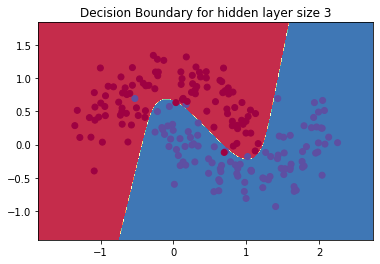

In [ ]:
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
import matplotlib
import operator
import time
 
def createData(dim=200, cnoise=0.20):
    """
    输出：数据集, 对应的类别标签
    描述：生成一个数据集和对应的类别标签
    """
    np.random.seed(0)
    X, y = sklearn.datasets.make_moons(dim, noise=cnoise)
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    #plt.show()
    return X, y
 
def plot_decision_boundary(pred_func, X, y):
    """
    输入：边界函数, 数据集, 类别标签
    描述：绘制决策边界(画图用)
    """
    # 设置最小最大值, 加上一点外边界
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # 根据最小最大值和一个网格距离生成整个网格
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 对整个网格预测边界值
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # 绘制边界和数据集的点
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
 
def calculate_loss(model, X, y):
    """
    输入：训练模型, 数据集, 类别标签
    输出：误判的概率
    描述：计算整个模型的性能
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 正向传播来计算预测的分类值
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # 计算误判概率
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # 加入正则项修正错误(可选)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss
 
def predict(model, x):
    """
    输入：训练模型, 预测向量
    输出：判决类别
    描述：预测类别属于(0 or 1)
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 正向传播计算
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)
 
def initParameter(X):
    """
    输入：数据集
    描述：初始化神经网络算法的参数
          必须初始化为全局函数！
          这里需要手动设置！
    """
    global num_examples
    num_examples = len(X) # 训练集的大小
    global nn_input_dim
    nn_input_dim = 2 # 输入层维数
    global nn_output_dim
    nn_output_dim = 2 # 输出层维数
 
    # 梯度下降参数
    global epsilon
    epsilon = 0.01 # 梯度下降学习步长
    global reg_lambda
    reg_lambda = 0.01 # 修正的指数
 
def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    """
    输入：数据集, 类别标签, 隐藏层层数, 迭代次数, 是否输出误判率
    输出：神经网络模型
    描述：生成一个指定层数的神经网络模型
    """
    # 根据维度随机初始化参数
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    model = {}
 
    # 梯度下降
    for i in range(0, num_passes):
        # 正向传播
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1) # 激活函数使用tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2) # 原始归一化
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # 后向传播
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        # 加入修正项
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        # 更新梯度下降参数
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        # 更新模型
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        # 一定迭代次数后输出当前误判率
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (i, calculate_loss(model, X, y)))
    plot_decision_boundary(lambda x: predict(model, x), X, y)
    plt.title("Decision Boundary for hidden layer size %d" % nn_hdim)
    #plt.show()
    return model
 
def main():
    dataSet, labels = createData(200, 0.20)
    initParameter(dataSet)
    nnModel = build_model(dataSet, labels, 3, print_loss=False)
    print("Loss is %f" % calculate_loss(nnModel, dataSet, labels))
 
if __name__ == '__main__':
    start = time.clock()
    main()
    end = time.clock()
    print('finish all in %s' % str(end - start))
    plt.show()